# 1. Sequential Models

In [1]:
import torch 
import torch.nn as nn
from torch.utils import data

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
from d2l import torch as d2l

Let's consider that you are trying to predict the **stock price $x_t$** at time $t$ given the **previous prices**:

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

## Autoregressive Model

**Regression** models can be used to solve this problem.

However, the **number of inputs** is dependent on the **time step $t$**, which raises as time passes. Therefore, we need find a way to **estimate** the input. That is, we are trying to estimate $P(x_t \mid x_{t-1}, \ldots, x_1)$.

> Method 1: (**`Autoregressive Models`**):
> - assuming that a long sequence $x_{t-1}, \ldots, x_1$ is not necessary, instead we only need to consider $x_{t-1}, \ldots, x_{t-\tau}$ (length $\tau$)
> - the number of parameters is fixed, allowing us to train a neural network
> - the model estimates $P(x_t \mid x_{t-1}, \ldots, x_1)$ with $P(x_{t-1}, \ldots, x_{t-\tau})$

> Method 2: (**`Latent Autoregressive Models`**):
> - maintain some summary $h_t$ of the past observations
> - update $h_t$ and make prediction $\hat{x}_t$ at the same time
> - the model estimates $x_t$ with $\hat{x}_t = P(x_t \mid h_{t})$
> - the model updates $h_t$ with $h_t = g(h_{t-1}, x_{t-1})$
> - since $h_t$ is never observed, they are hidden states
> ![](http://d2l.ai/_images/sequence-model.svg)

To generate **training data** for the above methods, we assume that the **dynamics** of the sequence is **stationary** while $x_t$ is changing. Therefore, we estimate the sequence with:

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1)$$

## Markov Models

In **autoregressive** models, we use $x_{t-1}, \ldots, x_{t-\tau}$ instead of $x_{t-1}, \ldots, x_1$ to estimate $x_t$.

Whenever we can **throw away** the history beyond $\tau$ without any **loss in predictive power**, we say that the sequence satistfies a **`Markov condition`**. That is, the future is conditionally **independent** of the past, given the recent history. 

For example, when $\tau = 1$, we have a **first-order Markov model**:

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1)$$

Such model is great when $x_t$ is **discrete**, where we can use **dynamic programming** to compute results along the **markov chain** efficiently and accurately. 

For example:

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

## Training

Let's first generate some data:

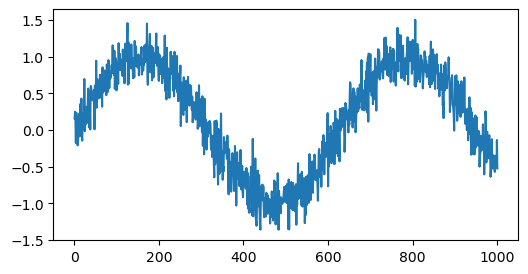

In [3]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(6, 3))
plt.plot(time, x)
plt.show()

Then, we transform the data into **feature-label** pairs: label is $x_t$ and features are $[x_{t-\tau}, ..., x_{t-1}]$.

When there are not enough historical observations (i.e. $<600$), we have two solutions:

1. **drop** the examples
2. **pad** the sequence with zeros

Here, we simply drop the examples with not enough features:

In [4]:
tau = 4

features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
    
labels = x[tau:].reshape((-1, 1))

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
batch_size, n_train = 16, 600
train_iter = load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

Here we use a simple **MLP** with two fully connected layers, ReLU activations and square loss:

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [8]:
loss = nn.MSELoss(reduction='none')

net = get_net()
train(net, train_iter, loss, epochs=5, lr=0.01)

epoch 1, loss: 0.055732
epoch 2, loss: 0.052020
epoch 3, loss: 0.051779
epoch 4, loss: 0.048606
epoch 5, loss: 0.048134


## Predictions

We first check the predicitve power of the model on **one-step-ahead prediction**:

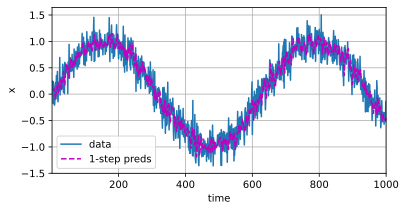

In [9]:
onestep_preds = net(features)

d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

Now, let's check how the model does on **k-step-ahead prediction** by making predictions based on predictions:

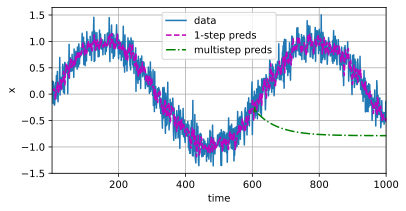

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]

for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1,-1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

As you can see, the performance of the model was very bad that the prediction soon decay to a constant. This is due to the **accumulation of errors** when making predictions based on predictions.